# ResNets


*   ResNet-18
*   ResNet-w2x(wider) -128 filters
*   ResNet-0.5x(narrower) - 32 filters
*   ResNet-164 - deep
https://pytorch-tutorial.readthedocs.io/en/latest/tutorial/chapter03_intermediate/3_2_2_cnn_resnet_cifar10/





In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import timm


import os

import matplotlib.pyplot as plt


device = torch.device('cuda')

In [2]:
import torch
print(torch.cuda.is_available())

True


# Download Data


train data length: 78
test data length: 78
tensor(7)
tensor(1)
tensor(0)


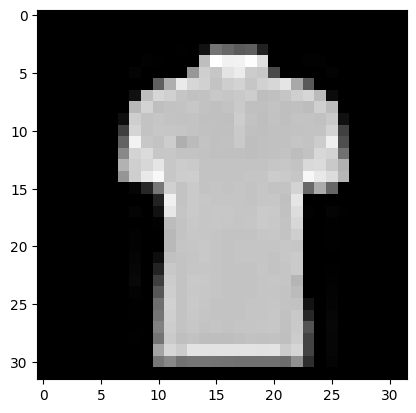

In [3]:
#config

TRAIN_SIZE  = 10000
BATCH_SIZE = 128
DATA  = "FMNIST"

##### DATA LOADER

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms


# Image preprocessing modules
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding = 4),
    transforms.ToTensor()])

if DATA == "FMNIST":
  data_set = FashionMNIST(
      # データセットのパス
      root='../../data/',
      train=True,
      # ダウンロードしている場合はdownload=False
      download=True,
      transform=transform
  )

  test_set = FashionMNIST(
      # データセットのパス
      root='../../data/',
      train=False,
      # ダウンロードしている場合はdownload=False
      download=True,
      transform=transform
  )
elif DATA == "MNIST":
  data_set = MNIST(
      # データセットのパス
      root='../../data/',
      train=True,
      # ダウンロードしている場合はdownload=False
      download=True,
      transform=transform
  )

  test_set = MNIST(
      # データセットのパス
      root='../../data/',
      train=False,
      # ダウンロードしている場合はdownload=False
      download=True,
      transform=transform
  )

data_set.data=data_set.data[:TRAIN_SIZE]
data_set.targets =data_set.targets[:TRAIN_SIZE]

data_loader = DataLoader(
    dataset=data_set, 
    batch_size=BATCH_SIZE,
    # シャッフルしない場合はshuffle=Flase
    shuffle=True,
    # batch_sizeを固定
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_set, 
    batch_size=BATCH_SIZE,
    # シャッフルしない場合はshuffle=Flase
    shuffle=True,
    # batch_sizeを固定
    drop_last=True
)

print("train data length:",len(data_loader))
print("test data length:",len(test_loader))

for idx, (inputs,label) in enumerate(test_loader):

    # move to device
    plt.imshow(inputs[0].reshape(32,32), cmap="gray")
    print(label[0])
    if idx == 2:
        break

In [26]:
#train
import torch
from torch import nn, optim
from tqdm import tqdm
def train(model, is_stitch = False,total_epoch: int=20):
   
    total_epoch = 64000//len(data_loader)+100
    # オプティマイザーの定義
    if is_stitch:
        optimizer = optim.Adam(
            params=model.parameters(),
            lr=0.001)
        # scheduler = optim.lr_scheduler.CosineAnnealingLR(
        #     optimizer=optimizer,
        # )
    else:
        optimizer = optim.SGD(
            params=model.parameters(),
            lr=0.05,
            weight_decay = 0.0001,
            momentum = 0.9
        )
        # スケジューラーの定義
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer=optimizer,
            milestones = [total_epoch//2,(total_epoch)*3//4],
            gamma = 0.2,
            last_epoch=-1, #change step to 64K 
        )

    # 損失関数の定義
    criterion = nn.CrossEntropyLoss()

    model.train()
    i= 0
    for epoch in range(total_epoch):
        accuracy, train_loss = 0.0, 0.0

        # tqdmを用いるとプログレスバーの表示ができる
        for images, labels in tqdm(data_loader):
            optimizer.zero_grad()
            images = images.to(device)
            labels = labels.to(device)

            # モデルからの出力
            out = model(images)
            # lossの算出
            loss = criterion(out, labels)

            loss.backward()
            optimizer.step()
            

            # 推測値
            preds = out.argmax(axis=1)

            train_loss += loss.item()
            # 正答率の算出
            accuracy += torch.sum(preds == labels).item() / len(labels)
            i+=1
            if i == 64000:
                return
        if not is_stitch:
            scheduler.step()

        # 値の出力
        print(f"epoch: {epoch + 1}")
        print(f"loss: {train_loss / len(data_loader)}")
        print(f"accuracy: {accuracy / len(data_loader)}")
  #  torch.save(model.state_dict(), "/content/drive/MyDrive/CompWeb/FMNISTmodel.pth")


In [5]:
def evaluate_model(model):
    correct = 0
    total = 0
    accuracy, test_loss = 0.0, 0.0
    criterion = nn.CrossEntropyLoss()
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # calculate outputs by running images through the network
            out = model(images)
            preds = out.argmax(axis = 1)
            # calculate loss from test
            loss = criterion(out, labels)
            test_loss += loss.item()
            accuracy += torch.sum(preds == labels).item() / len(labels)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(out.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %')
    print(f'Loss of the network on the 10000 test images: {100 * test_loss / len(test_loader)} %')

    print(f"loss: {test_loss / len(data_loader)}")
    print(f"accuracy: {accuracy / len(data_loader)}")

# Train Model

In [ ]:
from torch.nn import Conv2d
model    = timm.create_model(model_name = 'resnet18', pretrained = True)
model.conv1 = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 10)
model.to(device)
try:
    train(model,is_stitch=False)
except:
    torch.save(model.state_dict(), "/"+DATA+"ResNet18model"+str(TRAIN_SIZE)+".pth")
torch.save(model.state_dict(), "/"+DATA+"ResNet18model"+str(TRAIN_SIZE)+".pth")

# Reload Pretrained Model

In [40]:
#config
# MODELB->MODELA
#modelB
MODELB ="MNIST"
B_PATH = MODELB+"model/"+ MODELB +"ResNet18model10000.pth"

#modelA
MODELA ="FMNIST"
A_PATH = MODELA+"model/"+ MODELA +"ResNet18model10000.pth"

In [41]:
modelA  = timm.create_model(model_name = 'resnet18', pretrained = False)
modelA.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
modelA.fc = nn.Linear(512, 10)
modelA.to(device)

checkpoint = torch.load(A_PATH)
# load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
modelA.load_state_dict(checkpoint)
modelA.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [42]:
evaluate_model(modelA)

Accuracy of the network on the 10000 test images: 89.40304487179488 %
Loss of the network on the 10000 test images: 61.97518018575815 %
loss: 0.6197518018575815
accuracy: 0.8940304487179487


In [43]:
modelB  = timm.create_model(model_name = 'resnet18', pretrained = False)
modelB.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
modelB.fc = nn.Linear(512, 10)
modelB.to(device)

checkpoint = torch.load(B_PATH)
# load model weights state_dict
# model.load_state_dict(checkpoint['model_state_dict'])
modelB.load_state_dict(checkpoint)
modelB.eval()


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [44]:
evaluate_model(modelB)

Accuracy of the network on the 10000 test images: 6.460336538461538 %
Loss of the network on the 10000 test images: 714.202192502144 %
loss: 7.1420219250214405
accuracy: 0.06460336538461539


In [29]:
from torch.nn import Conv2d

def load_model(model):

  # load the model checkpoint
  checkpoint = torch.load('/content/drive/MyDrive/CompWeb/model.pth')
  # load model weights state_dict
  model.load_state_dict(checkpoint['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')
  # load trained optimizer state_dict
  #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')
  epochs = checkpoint['epoch']
  # load the criterion
  criterion = checkpoint['loss']
  print('Trained model loss function loaded...')
  print(f"Previously trained for {epochs} number of epochs...")
  # train for more epochs
  # epochs = new_epochs
  # print(f"Train for {epochs} more epochs...")


# Stitch Model class

In [45]:
class StitchedModel(nn.Module):
  def __init__(self, modelB, modelA):
    super(StitchedModel,self).__init__()
    #stitch layer 1 to  layer 2
    self.c1 = 64
    self.c2 = 64
    
    #buttom model
    self.modelBconv1 = modelB.conv1
    self.modelBbn1 = modelB.bn1
    self.modelBact1 = modelB.act1
    self.modelBmaxpool = modelB.maxpool
    self.modelBlayer1 = modelB.layer1
    self.modelBlayer2 = modelB.layer2
    self.modelBlayer3 = modelB.layer3
    self.modelBlayer4 = modelB.layer4
    self.modelBglobal_pool = modelB.global_pool
    self.modelBfc = modelB.fc
    
    #top model
    self.modelAconv1 = modelA.conv1
    self.modelAbn1 = modelA.bn1
    self.modelAact1 = modelA.act1
    self.modelAmaxpool = modelA.maxpool
    self.modelAlayer1 = modelA.layer1
    self.modelAlayer2 = modelA.layer2
    self.modelAlayer3 = modelA.layer3
    self.modelAlayer4 = modelA.layer4
    self.modelAglobal_pool = modelA.global_pool
    self.modelAfc = modelA.fc

    #stitching layer
    self.bn1 = nn.BatchNorm2d(self.c1)
    self.conv = nn.Conv2d(in_channels = self.c1, out_channels = self.c2,kernel_size=1)
    self.bn2 = nn.BatchNorm2d(self.c2)

  def forward(self,x):
    x=self.modelBconv1(x)   
    x=self.modelBbn1(x)   
    x=self.modelBact1(x)
    x=self.modelBmaxpool(x)   
    x=self.modelBlayer1(x)
    # x=self.modelBlayer2(x)
    # x=self.modelBlayer3(x)
    # x=self.modelBlayer4(x)
    # x=self.modelBglobal_pool(x)
    # x=self.modelBfc(x)
    
    x=self.bn1(x)
    x=self.conv(x)
    x=self.bn2(x)
    
    # x=self.modelAconv1(x)   
    # x=self.modelAbn1(x)   
    # x=self.modelAact1(x)
    # x=self.modelAmaxpool(x)   
    # x=self.modelAlayer1(x)
    x=self.modelAlayer2(x)
    x=self.modelAlayer3(x)
    x=self.modelAlayer4(x)
    x=self.modelAglobal_pool(x)
    x=self.modelAfc(x)

    return x



# Train Stitch Model

In [46]:
stitchmodel =StitchedModel(modelB, modelA).to(device)
#freeze layer
for param in stitchmodel.parameters():
    param.requires_grad = False

#unfreeze stitching layers
for param in stitchmodel.bn1.parameters():
    param.requires_grad = True

for param in stitchmodel.conv.parameters():
    param.requires_grad = True

for param in stitchmodel.bn2.parameters():
    param.requires_grad = True


In [47]:
evaluate_model(stitchmodel)

Accuracy of the network on the 10000 test images: 12.389823717948717 %
Loss of the network on the 10000 test images: 622.1071738463181 %
loss: 6.2210717384631815
accuracy: 0.12389823717948718


In [48]:
try:
    print("training"+MODELB+"to"+MODELA+"trainedon"+DATA+".......")
    train(stitchmodel,is_stitch=True)
except KeyboardInterrupt:
    pass
#torch.save(stitchmodel.state_dict(), "StitchedModel/"+MODELB+"to"+MODELA+"trainedon"+DATA+"2.pth")

model_scripted = torch.jit.script(stitchmodel) # Export to TorchScript
model_scripted.save("StitchedModel(layer1)/"+MODELB+"to"+MODELA+"trainedon"+DATA+".pth") # Save

trainingMNISTtoFMNISTtrainedonFMNIST.......


100%|██████████| 78/78 [00:03<00:00, 21.39it/s]


epoch: 1
loss: 2.118494987487793
accuracy: 0.63671875


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 2
loss: 0.8426458629278036
accuracy: 0.8232171474358975


100%|██████████| 78/78 [00:03<00:00, 21.82it/s]


epoch: 3
loss: 0.5983930776516596
accuracy: 0.8646834935897436


100%|██████████| 78/78 [00:03<00:00, 22.06it/s]


epoch: 4
loss: 0.4793994249059604
accuracy: 0.8920272435897436


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 5
loss: 0.41534710427125293
accuracy: 0.899238782051282


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 6
loss: 0.37840766708056134
accuracy: 0.9056490384615384


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 7
loss: 0.3222998816233415
accuracy: 0.91796875


100%|██████████| 78/78 [00:03<00:00, 21.83it/s]


epoch: 8
loss: 0.2970424812191572
accuracy: 0.9211738782051282


100%|██████████| 78/78 [00:03<00:00, 20.93it/s]


epoch: 9
loss: 0.2965296897559594
accuracy: 0.9213741987179487


100%|██████████| 78/78 [00:03<00:00, 21.57it/s]


epoch: 10
loss: 0.2719437973335003
accuracy: 0.9290865384615384


100%|██████████| 78/78 [00:03<00:00, 20.76it/s]


epoch: 11
loss: 0.2611742324362963
accuracy: 0.9313902243589743


100%|██████████| 78/78 [00:04<00:00, 18.74it/s]


epoch: 12
loss: 0.25336711997023
accuracy: 0.9347956730769231


100%|██████████| 78/78 [00:04<00:00, 19.36it/s]


epoch: 13
loss: 0.23133946525362822
accuracy: 0.9344951923076923


100%|██████████| 78/78 [00:03<00:00, 19.77it/s]


epoch: 14
loss: 0.23222162880194494
accuracy: 0.9370993589743589


100%|██████████| 78/78 [00:03<00:00, 20.46it/s]


epoch: 15
loss: 0.23176352517345014
accuracy: 0.9386017628205128


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 16
loss: 0.22048368371832064
accuracy: 0.9403044871794872


100%|██████████| 78/78 [00:03<00:00, 21.90it/s]


epoch: 17
loss: 0.20889761260686776
accuracy: 0.9424078525641025


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 18
loss: 0.20937639126219812
accuracy: 0.9430088141025641


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 19
loss: 0.21006241416892943
accuracy: 0.9439102564102564


100%|██████████| 78/78 [00:03<00:00, 20.91it/s]


epoch: 20
loss: 0.20379212240760142
accuracy: 0.944511217948718


100%|██████████| 78/78 [00:03<00:00, 20.37it/s]


epoch: 21
loss: 0.19466164311728415
accuracy: 0.9459134615384616


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch: 22
loss: 0.18839573683455968
accuracy: 0.9475160256410257


100%|██████████| 78/78 [00:03<00:00, 21.25it/s]


epoch: 23
loss: 0.19156937253398773
accuracy: 0.9450120192307693


100%|██████████| 78/78 [00:03<00:00, 20.39it/s]


epoch: 24
loss: 0.1837709334989389
accuracy: 0.9479166666666666


100%|██████████| 78/78 [00:03<00:00, 21.03it/s]


epoch: 25
loss: 0.18085059566566578
accuracy: 0.9491185897435898


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 26
loss: 0.18012810025650722
accuracy: 0.9467147435897436


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 27
loss: 0.18389765989895052
accuracy: 0.9488181089743589


100%|██████████| 78/78 [00:03<00:00, 21.47it/s]


epoch: 28
loss: 0.165433066443373
accuracy: 0.9520232371794872


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch: 29
loss: 0.17715976893519744
accuracy: 0.9486177884615384


100%|██████████| 78/78 [00:03<00:00, 21.86it/s]


epoch: 30
loss: 0.16361957248777914
accuracy: 0.9535256410256411


100%|██████████| 78/78 [00:03<00:00, 21.74it/s]


epoch: 31
loss: 0.17208001573976034
accuracy: 0.9513221153846154


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 32
loss: 0.16361541914729735
accuracy: 0.9553285256410257


100%|██████████| 78/78 [00:03<00:00, 21.21it/s]


epoch: 33
loss: 0.16093056531957325
accuracy: 0.9545272435897436


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 34
loss: 0.1525816083049927
accuracy: 0.9557291666666666


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 35
loss: 0.1602268938261729
accuracy: 0.9558293269230769


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 36
loss: 0.15746791596309498
accuracy: 0.9556290064102564


100%|██████████| 78/78 [00:03<00:00, 21.24it/s]


epoch: 37
loss: 0.15821918424887535
accuracy: 0.9547275641025641


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 38
loss: 0.15852886714184514
accuracy: 0.9565304487179487


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 39
loss: 0.1555485381768682
accuracy: 0.9576322115384616


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 40
loss: 0.15529005587674105
accuracy: 0.9554286858974359


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 41
loss: 0.1448689620129955
accuracy: 0.9590344551282052


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 42
loss: 0.14942587795070347
accuracy: 0.9563301282051282


100%|██████████| 78/78 [00:03<00:00, 21.57it/s]


epoch: 43
loss: 0.15068937494204596
accuracy: 0.9556290064102564


100%|██████████| 78/78 [00:03<00:00, 21.86it/s]


epoch: 44
loss: 0.14601450329885268
accuracy: 0.9583333333333334


100%|██████████| 78/78 [00:03<00:00, 21.40it/s]


epoch: 45
loss: 0.13947921542403025
accuracy: 0.956229967948718


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 46
loss: 0.15228844343278652
accuracy: 0.9564302884615384


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 47
loss: 0.14869090580405334
accuracy: 0.9553285256410257


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 48
loss: 0.14273952153057623
accuracy: 0.956229967948718


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 49
loss: 0.13311201718468696
accuracy: 0.9563301282051282


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 50
loss: 0.13941574519356856
accuracy: 0.9582331730769231


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 51
loss: 0.13847196366017064
accuracy: 0.9597355769230769


100%|██████████| 78/78 [00:03<00:00, 21.66it/s]


epoch: 52
loss: 0.14230874858987638
accuracy: 0.9593349358974359


100%|██████████| 78/78 [00:03<00:00, 21.90it/s]


epoch: 53
loss: 0.14519311062609538
accuracy: 0.9577323717948718


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 54
loss: 0.1302375400510545
accuracy: 0.9602363782051282


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 55
loss: 0.13298851371002504
accuracy: 0.9596354166666666


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 56
loss: 0.13181390116612116
accuracy: 0.9621394230769231


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 57
loss: 0.13370053570431012
accuracy: 0.9603365384615384


100%|██████████| 78/78 [00:03<00:00, 21.81it/s]


epoch: 58
loss: 0.1299597884122378
accuracy: 0.9634415064102564


100%|██████████| 78/78 [00:03<00:00, 21.41it/s]


epoch: 59
loss: 0.13566593024640894
accuracy: 0.9598357371794872


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 60
loss: 0.1328374904413254
accuracy: 0.9608373397435898


100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


epoch: 61
loss: 0.13496992204529354
accuracy: 0.9594350961538461


100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


epoch: 62
loss: 0.1282117956986603
accuracy: 0.961738782051282


100%|██████████| 78/78 [00:03<00:00, 21.60it/s]


epoch: 63
loss: 0.12332202078631291
accuracy: 0.9626402243589743


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 64
loss: 0.12093157791651976
accuracy: 0.9633413461538461


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 65
loss: 0.1309079508512066
accuracy: 0.9600360576923077


100%|██████████| 78/78 [00:03<00:00, 21.27it/s]


epoch: 66
loss: 0.11974444400328092
accuracy: 0.9629407051282052


100%|██████████| 78/78 [00:03<00:00, 21.41it/s]


epoch: 67
loss: 0.12948572642814654
accuracy: 0.9625400641025641


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 68
loss: 0.12373121235615168
accuracy: 0.9629407051282052


100%|██████████| 78/78 [00:03<00:00, 21.53it/s]


epoch: 69
loss: 0.1282363205563086
accuracy: 0.9609375


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 70
loss: 0.11924864712338416
accuracy: 0.9622395833333334


100%|██████████| 78/78 [00:03<00:00, 21.78it/s]


epoch: 71
loss: 0.1268702529084224
accuracy: 0.9620392628205128


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 72
loss: 0.1171298305480144
accuracy: 0.9641426282051282


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 73
loss: 0.1069484095638379
accuracy: 0.9660456730769231


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 74
loss: 0.11486738156049679
accuracy: 0.9639423076923077


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 75
loss: 0.10990106774111971
accuracy: 0.9632411858974359


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 76
loss: 0.11065944045400009
accuracy: 0.9658453525641025


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 77
loss: 0.10950897736713672
accuracy: 0.9669471153846154


100%|██████████| 78/78 [00:03<00:00, 21.90it/s]


epoch: 78
loss: 0.12255813881086233
accuracy: 0.9635416666666666


100%|██████████| 78/78 [00:03<00:00, 21.39it/s]


epoch: 79
loss: 0.11291348889995462
accuracy: 0.9661458333333334


100%|██████████| 78/78 [00:03<00:00, 21.82it/s]


epoch: 80
loss: 0.1163106621004259
accuracy: 0.9638421474358975


100%|██████████| 78/78 [00:03<00:00, 20.34it/s]


epoch: 81
loss: 0.11369886383032188
accuracy: 0.9652443910256411


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 82
loss: 0.12018708464426872
accuracy: 0.9615384615384616


100%|██████████| 78/78 [00:03<00:00, 21.94it/s]


epoch: 83
loss: 0.11900914539224826
accuracy: 0.9611378205128205


100%|██████████| 78/78 [00:03<00:00, 21.30it/s]


epoch: 84
loss: 0.12358282918397051
accuracy: 0.9637419871794872


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 85
loss: 0.11318407403543973
accuracy: 0.9638421474358975


100%|██████████| 78/78 [00:03<00:00, 21.50it/s]


epoch: 86
loss: 0.11168330679767025
accuracy: 0.9653445512820513


100%|██████████| 78/78 [00:03<00:00, 21.56it/s]


epoch: 87
loss: 0.10293677393108225
accuracy: 0.9684495192307693


100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


epoch: 88
loss: 0.11209947143036586
accuracy: 0.9650440705128205


100%|██████████| 78/78 [00:07<00:00, 10.72it/s]


epoch: 89
loss: 0.10978515749462904
accuracy: 0.9676482371794872


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 90
loss: 0.12131865790639168
accuracy: 0.9638421474358975


100%|██████████| 78/78 [00:03<00:00, 20.24it/s]


epoch: 91
loss: 0.1126823478545516
accuracy: 0.965645032051282


100%|██████████| 78/78 [00:06<00:00, 11.59it/s]


epoch: 92
loss: 0.11586094880476594
accuracy: 0.9646434294871795


100%|██████████| 78/78 [00:03<00:00, 21.28it/s]


epoch: 93
loss: 0.1169625636524497
accuracy: 0.9647435897435898


100%|██████████| 78/78 [00:04<00:00, 18.53it/s]


epoch: 94
loss: 0.10325431475081505
accuracy: 0.9663461538461539


100%|██████████| 78/78 [00:03<00:00, 20.13it/s]


epoch: 95
loss: 0.12088522720986451
accuracy: 0.9663461538461539


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 96
loss: 0.10206031380221248
accuracy: 0.9696514423076923


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 97
loss: 0.1083050890563008
accuracy: 0.9701522435897436


100%|██████████| 78/78 [00:03<00:00, 21.90it/s]


epoch: 98
loss: 0.10434744210961537
accuracy: 0.9667467948717948


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 99
loss: 0.11802412442958508
accuracy: 0.9644431089743589


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 100
loss: 0.10897345569892189
accuracy: 0.9668469551282052


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 101
loss: 0.10545779027952215
accuracy: 0.9660456730769231


100%|██████████| 78/78 [00:03<00:00, 21.35it/s]


epoch: 102
loss: 0.1012903622781428
accuracy: 0.9683493589743589


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 103
loss: 0.09697330820684631
accuracy: 0.9705528846153846


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 104
loss: 0.1036181853702053
accuracy: 0.9657451923076923


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 105
loss: 0.10786036153634389
accuracy: 0.9666466346153846


100%|██████████| 78/78 [00:03<00:00, 21.78it/s]


epoch: 106
loss: 0.1134656178406798
accuracy: 0.9666466346153846


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 107
loss: 0.09859362430870533
accuracy: 0.9674479166666666


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 108
loss: 0.09868795711260575
accuracy: 0.9683493589743589


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 109
loss: 0.09976874561741567
accuracy: 0.9698517628205128


100%|██████████| 78/78 [00:03<00:00, 21.37it/s]


epoch: 110
loss: 0.11211597475294884
accuracy: 0.9663461538461539


100%|██████████| 78/78 [00:03<00:00, 21.24it/s]


epoch: 111
loss: 0.10620769299566746
accuracy: 0.9668469551282052


100%|██████████| 78/78 [00:03<00:00, 21.24it/s]


epoch: 112
loss: 0.10417204760970214
accuracy: 0.96875


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 113
loss: 0.09396279770403336
accuracy: 0.9724559294871795


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 114
loss: 0.0999061563410438
accuracy: 0.9696514423076923


100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


epoch: 115
loss: 0.10143753757270482
accuracy: 0.9686498397435898


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 116
loss: 0.10164263569869292
accuracy: 0.9674479166666666


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 117
loss: 0.10652741018491678
accuracy: 0.967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.88it/s]


epoch: 118
loss: 0.10717710737401667
accuracy: 0.9657451923076923


100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


epoch: 119
loss: 0.1026728928136902
accuracy: 0.9697516025641025


100%|██████████| 78/78 [00:03<00:00, 21.40it/s]


epoch: 120
loss: 0.10195611651318195
accuracy: 0.9685496794871795


100%|██████████| 78/78 [00:03<00:00, 21.17it/s]


epoch: 121
loss: 0.09338922064321545
accuracy: 0.9710536858974359


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 122
loss: 0.09603790540057115
accuracy: 0.9699519230769231


100%|██████████| 78/78 [00:03<00:00, 21.65it/s]


epoch: 123
loss: 0.1021841871074568
accuracy: 0.9684495192307693


100%|██████████| 78/78 [00:03<00:00, 21.56it/s]


epoch: 124
loss: 0.11668866588017689
accuracy: 0.9639423076923077


100%|██████████| 78/78 [00:04<00:00, 17.35it/s]


epoch: 125
loss: 0.09318533255599248
accuracy: 0.9688501602564102


100%|██████████| 78/78 [00:04<00:00, 16.39it/s]


epoch: 126
loss: 0.0982843197356814
accuracy: 0.9693509615384616


100%|██████████| 78/78 [00:03<00:00, 20.20it/s]


epoch: 127
loss: 0.10484530251377668
accuracy: 0.9682491987179487


100%|██████████| 78/78 [00:03<00:00, 21.29it/s]


epoch: 128
loss: 0.11241306914971808
accuracy: 0.9670472756410257


100%|██████████| 78/78 [00:03<00:00, 21.19it/s]


epoch: 129
loss: 0.10948087055331622
accuracy: 0.9666466346153846


100%|██████████| 78/78 [00:03<00:00, 21.41it/s]


epoch: 130
loss: 0.09633825290709352
accuracy: 0.9701522435897436


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 131
loss: 0.09470796951642022
accuracy: 0.9690504807692307


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 132
loss: 0.0961823139148645
accuracy: 0.969551282051282


100%|██████████| 78/78 [00:03<00:00, 21.96it/s]


epoch: 133
loss: 0.09552407412765881
accuracy: 0.9690504807692307


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 134
loss: 0.11005745868747815
accuracy: 0.9678485576923077


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 135
loss: 0.10636587326343243
accuracy: 0.9674479166666666


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 136
loss: 0.10512004389714164
accuracy: 0.9690504807692307


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 137
loss: 0.0947514761907932
accuracy: 0.9693509615384616


100%|██████████| 78/78 [00:03<00:00, 21.67it/s]


epoch: 138
loss: 0.0957656890894167
accuracy: 0.9694511217948718


100%|██████████| 78/78 [00:03<00:00, 21.78it/s]


epoch: 139
loss: 0.0981183748644514
accuracy: 0.9684495192307693


100%|██████████| 78/78 [00:03<00:00, 21.85it/s]


epoch: 140
loss: 0.09166394020072542
accuracy: 0.9721554487179487


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 141
loss: 0.09126682598621418
accuracy: 0.9704527243589743


100%|██████████| 78/78 [00:03<00:00, 21.14it/s]


epoch: 142
loss: 0.10025769364661895
accuracy: 0.9703525641025641


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 143
loss: 0.0944852689997508
accuracy: 0.9673477564102564


100%|██████████| 78/78 [00:03<00:00, 21.60it/s]


epoch: 144
loss: 0.10055358268511601
accuracy: 0.9685496794871795


100%|██████████| 78/78 [00:03<00:00, 21.38it/s]


epoch: 145
loss: 0.10862520492325227
accuracy: 0.9666466346153846


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 146
loss: 0.10380096191492601
accuracy: 0.9677483974358975


100%|██████████| 78/78 [00:03<00:00, 21.80it/s]


epoch: 147
loss: 0.1018690589385537
accuracy: 0.9689503205128205


100%|██████████| 78/78 [00:03<00:00, 21.32it/s]


epoch: 148
loss: 0.09644453518259792
accuracy: 0.9704527243589743


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 149
loss: 0.10022446723320545
accuracy: 0.9688501602564102


100%|██████████| 78/78 [00:03<00:00, 21.56it/s]


epoch: 150
loss: 0.0898574986256277
accuracy: 0.9708533653846154


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 151
loss: 0.10705912422436552
accuracy: 0.9651442307692307


100%|██████████| 78/78 [00:03<00:00, 21.52it/s]


epoch: 152
loss: 0.09983199293940113
accuracy: 0.9697516025641025


100%|██████████| 78/78 [00:03<00:00, 21.75it/s]


epoch: 153
loss: 0.09098377001161377
accuracy: 0.9717548076923077


100%|██████████| 78/78 [00:03<00:00, 20.96it/s]


epoch: 154
loss: 0.09451290439718808
accuracy: 0.9710536858974359


100%|██████████| 78/78 [00:03<00:00, 20.22it/s]


epoch: 155
loss: 0.09292795973567244
accuracy: 0.9719551282051282


100%|██████████| 78/78 [00:04<00:00, 19.10it/s]


epoch: 156
loss: 0.10158910217265096
accuracy: 0.967948717948718


100%|██████████| 78/78 [00:03<00:00, 21.49it/s]


epoch: 157
loss: 0.09473829650773834
accuracy: 0.9705528846153846


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 158
loss: 0.09256285594967313
accuracy: 0.9698517628205128


100%|██████████| 78/78 [00:03<00:00, 21.71it/s]


epoch: 159
loss: 0.09893253666515915
accuracy: 0.9707532051282052


100%|██████████| 78/78 [00:03<00:00, 21.79it/s]


epoch: 160
loss: 0.09166145582611744
accuracy: 0.9702524038461539


100%|██████████| 78/78 [00:03<00:00, 21.71it/s]


epoch: 161
loss: 0.09546794264744489
accuracy: 0.9712540064102564


100%|██████████| 78/78 [00:03<00:00, 20.76it/s]


epoch: 162
loss: 0.09053633044449946
accuracy: 0.9709535256410257


100%|██████████| 78/78 [00:03<00:00, 21.20it/s]


epoch: 163
loss: 0.10177171711499493
accuracy: 0.9662459935897436


100%|██████████| 78/78 [00:04<00:00, 18.20it/s]


epoch: 164
loss: 0.0951847900899175
accuracy: 0.9688501602564102


100%|██████████| 78/78 [00:03<00:00, 20.11it/s]


epoch: 165
loss: 0.10242315994289058
accuracy: 0.9686498397435898


100%|██████████| 78/78 [00:03<00:00, 21.24it/s]


epoch: 166
loss: 0.09601726308942606
accuracy: 0.9701522435897436


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 167
loss: 0.09412948794376391
accuracy: 0.9688501602564102


100%|██████████| 78/78 [00:03<00:00, 21.50it/s]


epoch: 168
loss: 0.10069572116033389
accuracy: 0.9669471153846154


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 169
loss: 0.09833053446924075
accuracy: 0.9689503205128205


100%|██████████| 78/78 [00:03<00:00, 20.82it/s]


epoch: 170
loss: 0.09154055056233819
accuracy: 0.9712540064102564


100%|██████████| 78/78 [00:03<00:00, 21.16it/s]


epoch: 171
loss: 0.09099313133181287
accuracy: 0.9700520833333334


100%|██████████| 78/78 [00:03<00:00, 20.96it/s]


epoch: 172
loss: 0.10700154512260969
accuracy: 0.9653445512820513


100%|██████████| 78/78 [00:03<00:00, 21.29it/s]


epoch: 173
loss: 0.09535034822347836
accuracy: 0.9703525641025641


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 174
loss: 0.08827551220281002
accuracy: 0.9715544871794872


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 175
loss: 0.09220724156460701
accuracy: 0.9712540064102564


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 176
loss: 0.09562573817152625
accuracy: 0.9683493589743589


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch: 177
loss: 0.0894871867285707
accuracy: 0.9721554487179487


100%|██████████| 78/78 [00:03<00:00, 20.49it/s]


epoch: 178
loss: 0.09283913440333727
accuracy: 0.9696514423076923


100%|██████████| 78/78 [00:03<00:00, 21.33it/s]


epoch: 179
loss: 0.09426659489205728
accuracy: 0.9699519230769231


100%|██████████| 78/78 [00:03<00:00, 21.26it/s]


epoch: 180
loss: 0.08752720300346994
accuracy: 0.9720552884615384


100%|██████████| 78/78 [00:03<00:00, 21.21it/s]


epoch: 181
loss: 0.09513851941730349
accuracy: 0.9680488782051282


100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


epoch: 182
loss: 0.10284327851751676
accuracy: 0.9666466346153846


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 183
loss: 0.09636135359342472
accuracy: 0.9691506410256411


100%|██████████| 78/78 [00:03<00:00, 20.93it/s]


epoch: 184
loss: 0.08777281276595134
accuracy: 0.9715544871794872


100%|██████████| 78/78 [00:03<00:00, 21.61it/s]


epoch: 185
loss: 0.08874905910581732
accuracy: 0.9708533653846154


100%|██████████| 78/78 [00:03<00:00, 21.18it/s]


epoch: 186
loss: 0.09111066258106476
accuracy: 0.9706530448717948


100%|██████████| 78/78 [00:03<00:00, 21.29it/s]


epoch: 187
loss: 0.09625787607943401
accuracy: 0.9697516025641025


100%|██████████| 78/78 [00:03<00:00, 21.39it/s]


epoch: 188
loss: 0.08835552216101533
accuracy: 0.971854967948718


100%|██████████| 78/78 [00:03<00:00, 21.64it/s]


epoch: 189
loss: 0.09251287572372419
accuracy: 0.9692508012820513


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 190
loss: 0.08823462304635307
accuracy: 0.9714543269230769


100%|██████████| 78/78 [00:03<00:00, 21.45it/s]


epoch: 191
loss: 0.0879882268416576
accuracy: 0.9720552884615384


100%|██████████| 78/78 [00:03<00:00, 21.14it/s]


epoch: 192
loss: 0.098951328259248
accuracy: 0.9698517628205128


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 193
loss: 0.09941273614859734
accuracy: 0.9683493589743589


100%|██████████| 78/78 [00:03<00:00, 21.36it/s]


epoch: 194
loss: 0.08375318700638719
accuracy: 0.9717548076923077


100%|██████████| 78/78 [00:03<00:00, 21.56it/s]


epoch: 195
loss: 0.07915504260036425
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 21.24it/s]


epoch: 196
loss: 0.0838657177459353
accuracy: 0.9717548076923077


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch: 197
loss: 0.0975214156250541
accuracy: 0.9694511217948718


100%|██████████| 78/78 [00:03<00:00, 21.35it/s]


epoch: 198
loss: 0.09647465956946596
accuracy: 0.9686498397435898


100%|██████████| 78/78 [00:03<00:00, 21.24it/s]


epoch: 199
loss: 0.09153833092214206
accuracy: 0.9712540064102564


100%|██████████| 78/78 [00:03<00:00, 21.71it/s]


epoch: 200
loss: 0.09155210081893855
accuracy: 0.9711538461538461


100%|██████████| 78/78 [00:03<00:00, 21.40it/s]


epoch: 201
loss: 0.0856868336812999
accuracy: 0.9741586538461539


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch: 202
loss: 0.08882025439435473
accuracy: 0.9708533653846154


100%|██████████| 78/78 [00:03<00:00, 21.39it/s]


epoch: 203
loss: 0.10552249780784433
accuracy: 0.9664463141025641


100%|██████████| 78/78 [00:03<00:00, 21.43it/s]


epoch: 204
loss: 0.10153903308300635
accuracy: 0.9692508012820513


100%|██████████| 78/78 [00:03<00:00, 21.28it/s]


epoch: 205
loss: 0.08997972291679336
accuracy: 0.9724559294871795


100%|██████████| 78/78 [00:03<00:00, 21.20it/s]


epoch: 206
loss: 0.08712234383580299
accuracy: 0.9729567307692307


100%|██████████| 78/78 [00:03<00:00, 21.49it/s]


epoch: 207
loss: 0.08375219270013846
accuracy: 0.9711538461538461


100%|██████████| 78/78 [00:03<00:00, 20.95it/s]


epoch: 208
loss: 0.0938112524887308
accuracy: 0.9709535256410257


100%|██████████| 78/78 [00:04<00:00, 19.23it/s]


epoch: 209
loss: 0.08413937748768009
accuracy: 0.975761217948718


100%|██████████| 78/78 [00:03<00:00, 21.19it/s]


epoch: 210
loss: 0.09246194082049605
accuracy: 0.9702524038461539


100%|██████████| 78/78 [00:03<00:00, 21.66it/s]


epoch: 211
loss: 0.09047674706492287
accuracy: 0.9708533653846154


100%|██████████| 78/78 [00:03<00:00, 21.57it/s]


epoch: 212
loss: 0.08090478745408547
accuracy: 0.9742588141025641


100%|██████████| 78/78 [00:03<00:00, 21.74it/s]


epoch: 213
loss: 0.09688213854455031
accuracy: 0.9710536858974359


100%|██████████| 78/78 [00:04<00:00, 18.31it/s]


epoch: 214
loss: 0.08567036781460047
accuracy: 0.9730568910256411


100%|██████████| 78/78 [00:03<00:00, 19.80it/s]


epoch: 215
loss: 0.0880821320013358
accuracy: 0.9709535256410257


100%|██████████| 78/78 [00:03<00:00, 21.00it/s]


epoch: 216
loss: 0.09519782381800887
accuracy: 0.9711538461538461


100%|██████████| 78/78 [00:03<00:00, 21.34it/s]


epoch: 217
loss: 0.08484993335337211
accuracy: 0.9719551282051282


100%|██████████| 78/78 [00:03<00:00, 21.13it/s]


epoch: 218
loss: 0.08133682675468616
accuracy: 0.9738581730769231


100%|██████████| 78/78 [00:03<00:00, 21.63it/s]


epoch: 219
loss: 0.08266105204343031
accuracy: 0.97265625


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 220
loss: 0.08577271605220933
accuracy: 0.97265625


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 221
loss: 0.08969505399895403
accuracy: 0.9709535256410257


100%|██████████| 78/78 [00:03<00:00, 21.85it/s]


epoch: 222
loss: 0.08748717536815466
accuracy: 0.9714543269230769


100%|██████████| 78/78 [00:03<00:00, 21.58it/s]


epoch: 223
loss: 0.09019796276847139
accuracy: 0.9705528846153846


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 224
loss: 0.0926629720757214
accuracy: 0.9715544871794872


100%|██████████| 78/78 [00:03<00:00, 21.83it/s]


epoch: 225
loss: 0.09071700609265229
accuracy: 0.9722556089743589


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 226
loss: 0.08161265210797772
accuracy: 0.975761217948718


100%|██████████| 78/78 [00:03<00:00, 21.70it/s]


epoch: 227
loss: 0.07811412644477035
accuracy: 0.9750600961538461


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 228
loss: 0.08735731423187715
accuracy: 0.9741586538461539


100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


epoch: 229
loss: 0.08354460197285964
accuracy: 0.9727564102564102


100%|██████████| 78/78 [00:03<00:00, 21.79it/s]


epoch: 230
loss: 0.07560935636791281
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 231
loss: 0.07718797066272834
accuracy: 0.9730568910256411


100%|██████████| 78/78 [00:03<00:00, 21.05it/s]


epoch: 232
loss: 0.08447554214403798
accuracy: 0.9727564102564102


100%|██████████| 78/78 [00:03<00:00, 21.79it/s]


epoch: 233
loss: 0.0852889761997339
accuracy: 0.9723557692307693


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 234
loss: 0.08465616550678626
accuracy: 0.9712540064102564


100%|██████████| 78/78 [00:03<00:00, 20.68it/s]


epoch: 235
loss: 0.08052038613897868
accuracy: 0.973457532051282


100%|██████████| 78/78 [00:03<00:00, 21.89it/s]


epoch: 236
loss: 0.08941076316225988
accuracy: 0.9724559294871795


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 237
loss: 0.08101791036554062
accuracy: 0.9746594551282052


100%|██████████| 78/78 [00:03<00:00, 22.11it/s]


epoch: 238
loss: 0.09131250750177945
accuracy: 0.9730568910256411


100%|██████████| 78/78 [00:03<00:00, 21.01it/s]


epoch: 239
loss: 0.08374409351605348
accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:03<00:00, 21.06it/s]


epoch: 240
loss: 0.07501086054178767
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 20.90it/s]


epoch: 241
loss: 0.08776393583796632
accuracy: 0.9731570512820513


100%|██████████| 78/78 [00:03<00:00, 21.85it/s]


epoch: 242
loss: 0.08720406314405875
accuracy: 0.9724559294871795


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 243
loss: 0.08291182750597215
accuracy: 0.9729567307692307


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 244
loss: 0.08454333999767326
accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:03<00:00, 21.48it/s]


epoch: 245
loss: 0.08789610151105966
accuracy: 0.9713541666666666


100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


epoch: 246
loss: 0.0895486541140156
accuracy: 0.9705528846153846


100%|██████████| 78/78 [00:03<00:00, 21.71it/s]


epoch: 247
loss: 0.08614786360890438
accuracy: 0.9737580128205128


100%|██████████| 78/78 [00:03<00:00, 21.63it/s]


epoch: 248
loss: 0.0853039903852802
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 249
loss: 0.0846050299393634
accuracy: 0.9744591346153846


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 250
loss: 0.08732868840273184
accuracy: 0.9732572115384616


100%|██████████| 78/78 [00:03<00:00, 21.31it/s]


epoch: 251
loss: 0.08202170301228762
accuracy: 0.9740584935897436


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 252
loss: 0.08482333168220253
accuracy: 0.9725560897435898


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 253
loss: 0.08348316030624585
accuracy: 0.9721554487179487


100%|██████████| 78/78 [00:03<00:00, 22.03it/s]


epoch: 254
loss: 0.08990310302051978
accuracy: 0.9732572115384616


100%|██████████| 78/78 [00:03<00:00, 21.98it/s]


epoch: 255
loss: 0.0877277238939244
accuracy: 0.9709535256410257


100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


epoch: 256
loss: 0.08873848070223363
accuracy: 0.9733573717948718


100%|██████████| 78/78 [00:03<00:00, 21.77it/s]


epoch: 257
loss: 0.08869293603138664
accuracy: 0.9719551282051282


100%|██████████| 78/78 [00:03<00:00, 21.90it/s]


epoch: 258
loss: 0.08586491477222015
accuracy: 0.9725560897435898


100%|██████████| 78/78 [00:03<00:00, 22.04it/s]


epoch: 259
loss: 0.08636161336340965
accuracy: 0.9723557692307693


100%|██████████| 78/78 [00:03<00:00, 21.78it/s]


epoch: 260
loss: 0.0866966654594319
accuracy: 0.9716546474358975


100%|██████████| 78/78 [00:03<00:00, 22.06it/s]


epoch: 261
loss: 0.08300351704924534
accuracy: 0.9725560897435898


100%|██████████| 78/78 [00:03<00:00, 21.79it/s]


epoch: 262
loss: 0.08936329240289827
accuracy: 0.9730568910256411


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 263
loss: 0.08295010851743893
accuracy: 0.9728565705128205


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 264
loss: 0.0802116946150095
accuracy: 0.973457532051282


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 265
loss: 0.08430619503204258
accuracy: 0.9739583333333334


100%|██████████| 78/78 [00:03<00:00, 22.04it/s]


epoch: 266
loss: 0.08542383069363542
accuracy: 0.9735576923076923


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 267
loss: 0.08136852932138702
accuracy: 0.9732572115384616


100%|██████████| 78/78 [00:03<00:00, 21.62it/s]


epoch: 268
loss: 0.08572352007747842
accuracy: 0.9733573717948718


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 269
loss: 0.07566044716021189
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 270
loss: 0.08104082674552233
accuracy: 0.9735576923076923


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 271
loss: 0.07929875963152601
accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 272
loss: 0.07733297591599134
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 273
loss: 0.07543917348942696
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 21.63it/s]


epoch: 274
loss: 0.08593192017183472
accuracy: 0.9722556089743589


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 275
loss: 0.08705249145770302
accuracy: 0.971854967948718


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 276
loss: 0.07149821623729971
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 21.85it/s]


epoch: 277
loss: 0.08032593627770741
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 278
loss: 0.09651476796716452
accuracy: 0.9697516025641025


100%|██████████| 78/78 [00:03<00:00, 22.14it/s]


epoch: 279
loss: 0.09030609687145513
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 280
loss: 0.08619036925479005
accuracy: 0.9727564102564102


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 281
loss: 0.08555608456476758
accuracy: 0.9719551282051282


100%|██████████| 78/78 [00:03<00:00, 21.82it/s]


epoch: 282
loss: 0.08016933487632717
accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 283
loss: 0.08284937423797181
accuracy: 0.9738581730769231


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 284
loss: 0.08614953282551888
accuracy: 0.9732572115384616


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 285
loss: 0.08737952680064318
accuracy: 0.9717548076923077


100%|██████████| 78/78 [00:03<00:00, 22.02it/s]


epoch: 286
loss: 0.08340947684616996
accuracy: 0.9735576923076923


100%|██████████| 78/78 [00:03<00:00, 21.89it/s]


epoch: 287
loss: 0.08535102984079948
accuracy: 0.9732572115384616


100%|██████████| 78/78 [00:03<00:00, 21.84it/s]


epoch: 288
loss: 0.08271928223518607
accuracy: 0.9728565705128205


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 289
loss: 0.08017465133124436
accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 290
loss: 0.07991792212646359
accuracy: 0.9728565705128205


100%|██████████| 78/78 [00:03<00:00, 21.94it/s]


epoch: 291
loss: 0.07440103422133969
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 292
loss: 0.07903450354933739
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 22.04it/s]


epoch: 293
loss: 0.07620634003661764
accuracy: 0.9760616987179487


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 294
loss: 0.08645969942116584
accuracy: 0.9710536858974359


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 295
loss: 0.07822749312990943
accuracy: 0.9744591346153846


100%|██████████| 78/78 [00:03<00:00, 21.90it/s]


epoch: 296
loss: 0.07034691201093105
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 21.90it/s]


epoch: 297
loss: 0.09170349233616622
accuracy: 0.9692508012820513


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 298
loss: 0.08516391501642573
accuracy: 0.9715544871794872


100%|██████████| 78/78 [00:03<00:00, 22.02it/s]


epoch: 299
loss: 0.07577635089938457
accuracy: 0.9750600961538461


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 300
loss: 0.07192571570153515
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 21.72it/s]


epoch: 301
loss: 0.0829520053230226
accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 302
loss: 0.07296005392876956
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.01it/s]


epoch: 303
loss: 0.07364695652937278
accuracy: 0.9760616987179487


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 304
loss: 0.07839801175018343
accuracy: 0.9752604166666666


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 305
loss: 0.08126122101496619
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.03it/s]


epoch: 306
loss: 0.08907442850371201
accuracy: 0.9719551282051282


100%|██████████| 78/78 [00:03<00:00, 21.99it/s]


epoch: 307
loss: 0.07645633645976584
accuracy: 0.9746594551282052


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 308
loss: 0.08203701159725778
accuracy: 0.9728565705128205


100%|██████████| 78/78 [00:03<00:00, 22.02it/s]


epoch: 309
loss: 0.08760871818790641
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:03<00:00, 22.01it/s]


epoch: 310
loss: 0.08472371238689774
accuracy: 0.9725560897435898


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 311
loss: 0.07832545407402974
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 21.39it/s]


epoch: 312
loss: 0.09205502109267773
accuracy: 0.9715544871794872


100%|██████████| 78/78 [00:03<00:00, 21.35it/s]


epoch: 313
loss: 0.08451607868744013
accuracy: 0.9737580128205128


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 314
loss: 0.07604024627317603
accuracy: 0.9742588141025641


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 315
loss: 0.07439223205288634
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 22.03it/s]


epoch: 316
loss: 0.07838668459309982
accuracy: 0.9728565705128205


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 317
loss: 0.07696862540279444
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 318
loss: 0.07773877859402162
accuracy: 0.975761217948718


100%|██████████| 78/78 [00:03<00:00, 21.98it/s]


epoch: 319
loss: 0.07855762008171624
accuracy: 0.9749599358974359


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 320
loss: 0.08438745142223361
accuracy: 0.9732572115384616


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 321
loss: 0.08209753238285582
accuracy: 0.9733573717948718


100%|██████████| 78/78 [00:03<00:00, 22.14it/s]


epoch: 322
loss: 0.06768612448388758
accuracy: 0.9761618589743589


100%|██████████| 78/78 [00:03<00:00, 22.09it/s]


epoch: 323
loss: 0.08465425321497978
accuracy: 0.973457532051282


100%|██████████| 78/78 [00:03<00:00, 21.95it/s]


epoch: 324
loss: 0.07728552606959756
accuracy: 0.9735576923076923


100%|██████████| 78/78 [00:03<00:00, 21.93it/s]


epoch: 325
loss: 0.07841037823938024
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 326
loss: 0.07777494765244998
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 21.89it/s]


epoch: 327
loss: 0.07521777771389446
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 328
loss: 0.08042493494203648
accuracy: 0.9739583333333334


100%|██████████| 78/78 [00:03<00:00, 21.98it/s]


epoch: 329
loss: 0.07682259621409078
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 330
loss: 0.09052125228425631
accuracy: 0.9720552884615384


100%|██████████| 78/78 [00:03<00:00, 21.59it/s]


epoch: 331
loss: 0.06962219699739645
accuracy: 0.9769631410256411


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 332
loss: 0.07280924137777244
accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 333
loss: 0.07601552948546715
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 334
loss: 0.07013857559277079
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 21.51it/s]


epoch: 335
loss: 0.07569781569047616
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:05<00:00, 15.57it/s]


epoch: 336
loss: 0.0835986928238223
accuracy: 0.9740584935897436


100%|██████████| 78/78 [00:04<00:00, 16.27it/s]


epoch: 337
loss: 0.07254224790570636
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:08<00:00,  9.55it/s]


epoch: 338
loss: 0.07657400377763388
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 22.42it/s]


epoch: 339
loss: 0.08447044497081198
accuracy: 0.9720552884615384


100%|██████████| 78/78 [00:03<00:00, 19.62it/s]


epoch: 340
loss: 0.07440750225662039
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 20.96it/s]


epoch: 341
loss: 0.0819851944091706
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 342
loss: 0.07467790787967925
accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 343
loss: 0.07579159204107828
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 344
loss: 0.07708842536577812
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 21.98it/s]


epoch: 345
loss: 0.08438263173238972
accuracy: 0.9728565705128205


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 346
loss: 0.07314570906321304
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 347
loss: 0.07501107386241739
accuracy: 0.9740584935897436


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 348
loss: 0.07908886291373235
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 349
loss: 0.0803990329687412
accuracy: 0.9739583333333334


100%|██████████| 78/78 [00:03<00:00, 22.01it/s]


epoch: 350
loss: 0.07378824633092453
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.02it/s]


epoch: 351
loss: 0.07957874885640848
accuracy: 0.9733573717948718


100%|██████████| 78/78 [00:03<00:00, 22.14it/s]


epoch: 352
loss: 0.08087207424717072
accuracy: 0.9746594551282052


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 353
loss: 0.07333367662683415
accuracy: 0.9750600961538461


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 354
loss: 0.08245914719568995
accuracy: 0.9746594551282052


100%|██████████| 78/78 [00:03<00:00, 22.37it/s]


epoch: 355
loss: 0.07359485948482195
accuracy: 0.975761217948718


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 356
loss: 0.08568567944427904
accuracy: 0.9728565705128205


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 357
loss: 0.08647951144629563
accuracy: 0.9732572115384616


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 358
loss: 0.07572179110959554
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 359
loss: 0.07533637440214172
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 360
loss: 0.07471038964696419
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.41it/s]


epoch: 361
loss: 0.07971282819142708
accuracy: 0.9735576923076923


100%|██████████| 78/78 [00:03<00:00, 21.99it/s]


epoch: 362
loss: 0.08834095576849695
accuracy: 0.9714543269230769


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 363
loss: 0.07930178761195678
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 21.79it/s]


epoch: 364
loss: 0.08065046411222564
accuracy: 0.9742588141025641


100%|██████████| 78/78 [00:03<00:00, 22.36it/s]


epoch: 365
loss: 0.0840893254424326
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 366
loss: 0.07430183190482263
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 22.03it/s]


epoch: 367
loss: 0.08223762533937891
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 368
loss: 0.08524434732941863
accuracy: 0.9735576923076923


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 369
loss: 0.07263108836009334
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 370
loss: 0.0692035923532855
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 371
loss: 0.06932902123588018
accuracy: 0.9759615384615384


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 372
loss: 0.07934882983457871
accuracy: 0.9737580128205128


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 373
loss: 0.0717608691431964
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 374
loss: 0.08653942360065113
accuracy: 0.9717548076923077


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 375
loss: 0.07860757854695503
accuracy: 0.9754607371794872


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 376
loss: 0.08012942368021378
accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 377
loss: 0.07848878608992657
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 378
loss: 0.08191744100827819
accuracy: 0.9737580128205128


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 379
loss: 0.07849898376167776
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 380
loss: 0.07560837097489873
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 381
loss: 0.0800622984026678
accuracy: 0.9730568910256411


100%|██████████| 78/78 [00:03<00:00, 21.94it/s]


epoch: 382
loss: 0.07755498443610775
accuracy: 0.9749599358974359


100%|██████████| 78/78 [00:03<00:00, 22.36it/s]


epoch: 383
loss: 0.07347794786955301
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 384
loss: 0.08052977985845736
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.04it/s]


epoch: 385
loss: 0.07354410066723059
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 386
loss: 0.07874911449228723
accuracy: 0.9723557692307693


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 387
loss: 0.07428076689636025
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 388
loss: 0.07137491292535113
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 21.89it/s]


epoch: 389
loss: 0.07669985411354364
accuracy: 0.9738581730769231


100%|██████████| 78/78 [00:03<00:00, 22.14it/s]


epoch: 390
loss: 0.07462390127758949
accuracy: 0.9746594551282052


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 391
loss: 0.0779681366820557
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 392
loss: 0.07733926800294565
accuracy: 0.9739583333333334


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 393
loss: 0.06876195050799885
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 394
loss: 0.07487983686419633
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 395
loss: 0.07229093419244656
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 396
loss: 0.07126048298624273
accuracy: 0.9761618589743589


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 397
loss: 0.07141890566652784
accuracy: 0.9769631410256411


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 398
loss: 0.07500286387184109
accuracy: 0.975761217948718


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 399
loss: 0.0756943435049974
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 400
loss: 0.07542006032636915
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 401
loss: 0.07441497177410966
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 21.55it/s]


epoch: 402
loss: 0.07238607255455393
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 403
loss: 0.08402056129386601
accuracy: 0.9724559294871795


100%|██████████| 78/78 [00:03<00:00, 21.69it/s]


epoch: 404
loss: 0.0758803404437808
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 405
loss: 0.08092959166671602
accuracy: 0.9737580128205128


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 406
loss: 0.07769417840366562
accuracy: 0.9735576923076923


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 407
loss: 0.07790744175406125
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 408
loss: 0.08001283215633474
accuracy: 0.9744591346153846


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 409
loss: 0.07801090850709723
accuracy: 0.9738581730769231


100%|██████████| 78/78 [00:03<00:00, 22.04it/s]


epoch: 410
loss: 0.07514058996159105
accuracy: 0.973457532051282


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 411
loss: 0.07364897287856692
accuracy: 0.9750600961538461


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 412
loss: 0.0804601009362019
accuracy: 0.9736578525641025


100%|██████████| 78/78 [00:03<00:00, 22.04it/s]


epoch: 413
loss: 0.07866994630640899
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 414
loss: 0.07692166583803602
accuracy: 0.973457532051282


100%|██████████| 78/78 [00:03<00:00, 21.92it/s]


epoch: 415
loss: 0.07830472223651715
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 416
loss: 0.07489763091031748
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 417
loss: 0.07507067378490972
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.09it/s]


epoch: 418
loss: 0.07271588471933053
accuracy: 0.9752604166666666


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 419
loss: 0.07219065583716983
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 420
loss: 0.06796994787425949
accuracy: 0.9776642628205128


100%|██████████| 78/78 [00:03<00:00, 21.76it/s]


epoch: 421
loss: 0.08005199740187098
accuracy: 0.9741586538461539


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 422
loss: 0.08004604934308773
accuracy: 0.9750600961538461


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 423
loss: 0.07392051023765443
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 21.54it/s]


epoch: 424
loss: 0.07049365845532754
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 425
loss: 0.07660062740055415
accuracy: 0.9744591346153846


100%|██████████| 78/78 [00:03<00:00, 22.14it/s]


epoch: 426
loss: 0.0730581365716763
accuracy: 0.9754607371794872


100%|██████████| 78/78 [00:03<00:00, 22.45it/s]


epoch: 427
loss: 0.07513969811276557
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:03<00:00, 22.11it/s]


epoch: 428
loss: 0.07505915842305583
accuracy: 0.9737580128205128


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 429
loss: 0.06953998724332987
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 21.97it/s]


epoch: 430
loss: 0.07444532295593466
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 431
loss: 0.06690827836521351
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 432
loss: 0.07876073330258712
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 433
loss: 0.07322880348716027
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 434
loss: 0.0759841741170161
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 21.95it/s]


epoch: 435
loss: 0.07347136100706382
accuracy: 0.975761217948718


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 436
loss: 0.06345159114481738
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.41it/s]


epoch: 437
loss: 0.08285128106124318
accuracy: 0.9731570512820513


100%|██████████| 78/78 [00:03<00:00, 21.89it/s]


epoch: 438
loss: 0.07255847750900266
accuracy: 0.9780649038461539


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 439
loss: 0.0697259069300997
accuracy: 0.9759615384615384


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 440
loss: 0.06701073785109493
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 441
loss: 0.07469499410870366
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 442
loss: 0.07816887214684333
accuracy: 0.9746594551282052


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 443
loss: 0.07388541663590914
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 444
loss: 0.07082154484800039
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 445
loss: 0.07672197663655075
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 446
loss: 0.07957536955244648
accuracy: 0.9742588141025641


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 447
loss: 0.06920562157980524
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.11it/s]


epoch: 448
loss: 0.07425906500802973
accuracy: 0.9778645833333334


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 449
loss: 0.07618706573385936
accuracy: 0.9740584935897436


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 450
loss: 0.07091293733220738
accuracy: 0.9752604166666666


100%|██████████| 78/78 [00:03<00:00, 21.94it/s]


epoch: 451
loss: 0.0722291480558805
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 21.82it/s]


epoch: 452
loss: 0.08076051535466924
accuracy: 0.97265625


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 453
loss: 0.0741484083641225
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 22.30it/s]


epoch: 454
loss: 0.07193073645257989
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 455
loss: 0.06572446067077227
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.42it/s]


epoch: 456
loss: 0.07457420869300571
accuracy: 0.9759615384615384


100%|██████████| 78/78 [00:03<00:00, 22.06it/s]


epoch: 457
loss: 0.0730472830697321
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 458
loss: 0.06914095100588523
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 459
loss: 0.07112662130608581
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 460
loss: 0.06370616028419672
accuracy: 0.9788661858974359


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 461
loss: 0.06365881045945944
accuracy: 0.9780649038461539


100%|██████████| 78/78 [00:03<00:00, 22.44it/s]


epoch: 462
loss: 0.0747784042898088
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 463
loss: 0.06834850219102243
accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:03<00:00, 22.30it/s]


epoch: 464
loss: 0.07053010382999976
accuracy: 0.9783653846153846


100%|██████████| 78/78 [00:03<00:00, 21.86it/s]


epoch: 465
loss: 0.06531835939042652
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 466
loss: 0.07454281849547839
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 467
loss: 0.07110075783939698
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 468
loss: 0.07486668578946055
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 469
loss: 0.06466453776169473
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 470
loss: 0.06699343551941311
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 471
loss: 0.07452696537933289
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 21.73it/s]


epoch: 472
loss: 0.0722597696675131
accuracy: 0.9765625


100%|██████████| 78/78 [00:04<00:00, 18.08it/s]


epoch: 473
loss: 0.08035604482612167
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:03<00:00, 21.85it/s]


epoch: 474
loss: 0.07002715723445782
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 475
loss: 0.07824182723505566
accuracy: 0.9740584935897436


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 476
loss: 0.0695319742632982
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 477
loss: 0.07995641113330539
accuracy: 0.9742588141025641


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 478
loss: 0.07852411802667074
accuracy: 0.9739583333333334


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 479
loss: 0.0746785530474228
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 480
loss: 0.07597746088121755
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 481
loss: 0.07324893640067714
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.30it/s]


epoch: 482
loss: 0.08033620915972652
accuracy: 0.9728565705128205


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 483
loss: 0.08146041155291292
accuracy: 0.9738581730769231


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 484
loss: 0.06581729541843136
accuracy: 0.9789663461538461


100%|██████████| 78/78 [00:03<00:00, 22.35it/s]


epoch: 485
loss: 0.06446853778563821
accuracy: 0.9785657051282052


100%|██████████| 78/78 [00:03<00:00, 22.46it/s]


epoch: 486
loss: 0.07599348275181957
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 487
loss: 0.07734979341666286
accuracy: 0.9750600961538461


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 488
loss: 0.0669221856380598
accuracy: 0.9786658653846154


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 489
loss: 0.06890172817004032
accuracy: 0.9779647435897436


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 490
loss: 0.0704321156327541
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 491
loss: 0.06871501182635817
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.42it/s]


epoch: 492
loss: 0.08605150093969244
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 493
loss: 0.07280861705732651
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 494
loss: 0.0753145911014424
accuracy: 0.9750600961538461


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 495
loss: 0.07271146522954297
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 496
loss: 0.07418944583369945
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 497
loss: 0.06507984180457126
accuracy: 0.9792668269230769


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 498
loss: 0.06942305981348722
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 499
loss: 0.07017394482420805
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 500
loss: 0.06592480392935567
accuracy: 0.9783653846153846


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 501
loss: 0.06643391611914222
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 502
loss: 0.08101633654381984
accuracy: 0.9730568910256411


100%|██████████| 78/78 [00:03<00:00, 22.42it/s]


epoch: 503
loss: 0.07216763872509965
accuracy: 0.9759615384615384


100%|██████████| 78/78 [00:03<00:00, 21.87it/s]


epoch: 504
loss: 0.06161080796319323
accuracy: 0.9790665064102564


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 505
loss: 0.07368168929138054
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 506
loss: 0.07446719073236753
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 507
loss: 0.0666938811325683
accuracy: 0.9778645833333334


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 508
loss: 0.06847506672000656
accuracy: 0.9779647435897436


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 509
loss: 0.06960392941553624
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 510
loss: 0.07684567974259456
accuracy: 0.9728565705128205


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 511
loss: 0.07204299872645582
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 512
loss: 0.07140044377257045
accuracy: 0.9759615384615384


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 513
loss: 0.07450527919886205
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 514
loss: 0.06771900624227829
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 515
loss: 0.0694169347287896
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 516
loss: 0.07030746090607956
accuracy: 0.9759615384615384


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 517
loss: 0.07764603599953727
accuracy: 0.9744591346153846


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 518
loss: 0.06927569988422477
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 519
loss: 0.07982971452367611
accuracy: 0.973457532051282


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 520
loss: 0.07094948083305588
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 521
loss: 0.07686813918348306
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 522
loss: 0.065279315948152
accuracy: 0.9798677884615384


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 523
loss: 0.07299225094417731
accuracy: 0.9747596153846154


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 524
loss: 0.07691089289549452
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 525
loss: 0.0747171145123549
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 526
loss: 0.07440974122175995
accuracy: 0.9761618589743589


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 527
loss: 0.07398999955218571
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 528
loss: 0.07132368752111991
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 529
loss: 0.060873021968664266
accuracy: 0.9791666666666666


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 530
loss: 0.07140673479686181
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 531
loss: 0.07121466661994465
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 532
loss: 0.07514205681255613
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 533
loss: 0.06476145390815173
accuracy: 0.9786658653846154


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 534
loss: 0.06796392180527058
accuracy: 0.9778645833333334


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 535
loss: 0.06946733565284656
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 536
loss: 0.0653151470857362
accuracy: 0.9793669871794872


100%|██████████| 78/78 [00:03<00:00, 22.45it/s]


epoch: 537
loss: 0.07025858109446768
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 538
loss: 0.08532849837763187
accuracy: 0.9716546474358975


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 539
loss: 0.06927265600564006
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 540
loss: 0.0763966695835384
accuracy: 0.9742588141025641


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 541
loss: 0.06581849752304454
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 542
loss: 0.07862077253416945
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch: 543
loss: 0.07405920536854328
accuracy: 0.9759615384615384


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 544
loss: 0.06528631725515692
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 545
loss: 0.07516497207614474
accuracy: 0.9749599358974359


100%|██████████| 78/78 [00:03<00:00, 21.85it/s]


epoch: 546
loss: 0.0654054647610069
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 547
loss: 0.07028630129897441
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 548
loss: 0.06997434242079273
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 549
loss: 0.07238367673320074
accuracy: 0.975761217948718


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 550
loss: 0.07006573005436131
accuracy: 0.9774639423076923


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 551
loss: 0.07572804822419317
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 552
loss: 0.07100570280677997
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 20.98it/s]


epoch: 553
loss: 0.0698244015339953
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 21.74it/s]


epoch: 554
loss: 0.06892348099977542
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 21.42it/s]


epoch: 555
loss: 0.06491640734319122
accuracy: 0.9760616987179487


100%|██████████| 78/78 [00:03<00:00, 21.46it/s]


epoch: 556
loss: 0.0662071359081146
accuracy: 0.9783653846153846


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 557
loss: 0.068920848879199
accuracy: 0.9780649038461539


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 558
loss: 0.06855751815228125
accuracy: 0.9761618589743589


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 559
loss: 0.07234088012662071
accuracy: 0.9754607371794872


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 560
loss: 0.06707497079594013
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 561
loss: 0.07626132073943527
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 562
loss: 0.0761967409724513
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 563
loss: 0.069634150648012
accuracy: 0.975761217948718


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 564
loss: 0.0670895589252886
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 565
loss: 0.07236766732799318
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.01it/s]


epoch: 566
loss: 0.07456253680925912
accuracy: 0.9754607371794872


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 567
loss: 0.06957170213811481
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.02it/s]


epoch: 568
loss: 0.06069950396433855
accuracy: 0.9789663461538461


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 569
loss: 0.07010852586095914
accuracy: 0.9776642628205128


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 570
loss: 0.06508401662517244
accuracy: 0.979667467948718


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 571
loss: 0.07921272446998419
accuracy: 0.9732572115384616


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 572
loss: 0.06628917134665431
accuracy: 0.9776642628205128


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 573
loss: 0.06957023478566836
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 574
loss: 0.06458168860095051
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 575
loss: 0.06857613544576825
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 21.98it/s]


epoch: 576
loss: 0.07469613742656432
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 577
loss: 0.06955316869947964
accuracy: 0.9783653846153846


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 578
loss: 0.06962638393713114
accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 579
loss: 0.06455014434117728
accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 580
loss: 0.05774764929157801
accuracy: 0.9806690705128205


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 581
loss: 0.07538018000121109
accuracy: 0.9752604166666666


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 582
loss: 0.06745147285982966
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 583
loss: 0.07123968469647643
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 584
loss: 0.06986338793276212
accuracy: 0.9783653846153846


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 585
loss: 0.06726347608491778
accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:03<00:00, 22.04it/s]


epoch: 586
loss: 0.06898376364738514
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 587
loss: 0.0654945387534845
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:04<00:00, 19.27it/s]


epoch: 588
loss: 0.07126173837922323
accuracy: 0.9746594551282052


100%|██████████| 78/78 [00:05<00:00, 15.37it/s]


epoch: 589
loss: 0.07057449688466313
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 21.95it/s]


epoch: 590
loss: 0.06580572092356399
accuracy: 0.9769631410256411


100%|██████████| 78/78 [00:05<00:00, 14.36it/s]


epoch: 591
loss: 0.06635149809507987
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:04<00:00, 18.35it/s]


epoch: 592
loss: 0.0728581591676443
accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 593
loss: 0.07396691712216498
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:04<00:00, 18.72it/s]


epoch: 594
loss: 0.06893590149971154
accuracy: 0.9752604166666666


100%|██████████| 78/78 [00:03<00:00, 21.68it/s]


epoch: 595
loss: 0.06836660109006633
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 22.42it/s]


epoch: 596
loss: 0.07227112133151446
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.44it/s]


epoch: 597
loss: 0.07168245323312779
accuracy: 0.9744591346153846


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch: 598
loss: 0.06876131001477823
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 599
loss: 0.06940169721388091
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 600
loss: 0.07434495485339983
accuracy: 0.9751602564102564


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 601
loss: 0.06919600871893075
accuracy: 0.9761618589743589


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 602
loss: 0.07174811201790969
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 603
loss: 0.06285594283149411
accuracy: 0.9785657051282052


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 604
loss: 0.06645739774028651
accuracy: 0.979667467948718


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 605
loss: 0.07054328081460717
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.49it/s]


epoch: 606
loss: 0.06959664382828543
accuracy: 0.9761618589743589


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 607
loss: 0.06668519583315803
accuracy: 0.9754607371794872


100%|██████████| 78/78 [00:03<00:00, 22.35it/s]


epoch: 608
loss: 0.06958060902662766
accuracy: 0.9779647435897436


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 609
loss: 0.06385388989479114
accuracy: 0.9780649038461539


100%|██████████| 78/78 [00:03<00:00, 22.30it/s]


epoch: 610
loss: 0.0675001583623294
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 611
loss: 0.07171905235065004
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.41it/s]


epoch: 612
loss: 0.0718754161005983
accuracy: 0.9776642628205128


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 613
loss: 0.07618001979799607
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 614
loss: 0.07420836550255235
accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 615
loss: 0.0697447120044858
accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:03<00:00, 22.35it/s]


epoch: 616
loss: 0.06640367879747198
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 617
loss: 0.06561778065485832
accuracy: 0.9792668269230769


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 618
loss: 0.07804360543974699
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 619
loss: 0.06847385213208887
accuracy: 0.9774639423076923


100%|██████████| 78/78 [00:03<00:00, 22.35it/s]


epoch: 620
loss: 0.07331716844764276
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 621
loss: 0.0699812178977598
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 622
loss: 0.059789207501289174
accuracy: 0.9790665064102564


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 623
loss: 0.06966976689485212
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 624
loss: 0.06489350598377104
accuracy: 0.9788661858974359


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 625
loss: 0.0714634128082066
accuracy: 0.9759615384615384


100%|██████████| 78/78 [00:03<00:00, 22.46it/s]


epoch: 626
loss: 0.059993747932215534
accuracy: 0.9800681089743589


100%|██████████| 78/78 [00:03<00:00, 22.40it/s]


epoch: 627
loss: 0.06712627297458358
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 628
loss: 0.07903886589412697
accuracy: 0.9746594551282052


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 629
loss: 0.06927165918004437
accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:03<00:00, 22.41it/s]


epoch: 630
loss: 0.06465942001877686
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch: 631
loss: 0.06797565599807943
accuracy: 0.9774639423076923


100%|██████████| 78/78 [00:03<00:00, 22.35it/s]


epoch: 632
loss: 0.06419572479521427
accuracy: 0.9793669871794872


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 633
loss: 0.07481636364574139
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 634
loss: 0.07021106991809435
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 635
loss: 0.06003241447540812
accuracy: 0.981270032051282


100%|██████████| 78/78 [00:03<00:00, 22.06it/s]


epoch: 636
loss: 0.0666560981518183
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 637
loss: 0.06824643268154408
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.46it/s]


epoch: 638
loss: 0.07044067733491269
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 21.44it/s]


epoch: 639
loss: 0.07083134253461583
accuracy: 0.9748597756410257


100%|██████████| 78/78 [00:03<00:00, 19.75it/s]


epoch: 640
loss: 0.06823697600227135
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 21.02it/s]


epoch: 641
loss: 0.0694046210593138
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 642
loss: 0.06936769354610871
accuracy: 0.9782652243589743


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 643
loss: 0.06940245064787376
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 22.48it/s]


epoch: 644
loss: 0.06722715640894304
accuracy: 0.9760616987179487


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 645
loss: 0.0692261162882623
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.36it/s]


epoch: 646
loss: 0.07199959753033443
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 647
loss: 0.07193813376868956
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.36it/s]


epoch: 648
loss: 0.06528273405722128
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 649
loss: 0.06856455161678007
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 650
loss: 0.06228735510450907
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 651
loss: 0.06623164430642739
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 652
loss: 0.06325643793202172
accuracy: 0.9774639423076923


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 653
loss: 0.06803320643181603
accuracy: 0.9769631410256411


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 654
loss: 0.07496010530620623
accuracy: 0.9742588141025641


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 655
loss: 0.07442872383846687
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.06it/s]


epoch: 656
loss: 0.07130033269715615
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 657
loss: 0.06406439359610279
accuracy: 0.9780649038461539


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 658
loss: 0.07555369793986663
accuracy: 0.9744591346153846


100%|██████████| 78/78 [00:03<00:00, 22.00it/s]


epoch: 659
loss: 0.07005929599145953
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 660
loss: 0.07109814887054455
accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 661
loss: 0.0608849373096839
accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch: 662
loss: 0.0626983533326823
accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 663
loss: 0.07188052471536092
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 664
loss: 0.07057941033510873
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 665
loss: 0.06561525084842475
accuracy: 0.9786658653846154


100%|██████████| 78/78 [00:03<00:00, 22.46it/s]


epoch: 666
loss: 0.07376603250845502
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.30it/s]


epoch: 667
loss: 0.07255621779805575
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 668
loss: 0.06971748511736783
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 669
loss: 0.06639315168827008
accuracy: 0.9769631410256411


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 670
loss: 0.06661951324592034
accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:03<00:00, 22.09it/s]


epoch: 671
loss: 0.06856409928355461
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch: 672
loss: 0.06567142783210446
accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 673
loss: 0.07560138293924049
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 674
loss: 0.06307507902742006
accuracy: 0.975761217948718


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 675
loss: 0.07214953893652329
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 676
loss: 0.07156914179750647
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.41it/s]


epoch: 677
loss: 0.07102944504899475
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.14it/s]


epoch: 678
loss: 0.0684968426835556
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 679
loss: 0.06001996765366922
accuracy: 0.9790665064102564


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 680
loss: 0.065098363512124
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 681
loss: 0.07225425370658438
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 682
loss: 0.07017333711234805
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch: 683
loss: 0.06131797348961043
accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 684
loss: 0.07320942358973508
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 685
loss: 0.06416091271556723
accuracy: 0.9788661858974359


100%|██████████| 78/78 [00:03<00:00, 22.42it/s]


epoch: 686
loss: 0.07853648631284252
accuracy: 0.9761618589743589


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 687
loss: 0.07012152913898134
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 688
loss: 0.07265979640830594
accuracy: 0.9745592948717948


100%|██████████| 78/78 [00:03<00:00, 22.36it/s]


epoch: 689
loss: 0.07146805477065918
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 690
loss: 0.06806675700518565
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 691
loss: 0.06767814884630916
accuracy: 0.9769631410256411


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 692
loss: 0.06867846803596386
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.06it/s]


epoch: 693
loss: 0.07085850345902145
accuracy: 0.9778645833333334


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 694
loss: 0.06488911448739088
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.40it/s]


epoch: 695
loss: 0.06238325007815057
accuracy: 0.9793669871794872


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 696
loss: 0.061045404081829846
accuracy: 0.9776642628205128


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 697
loss: 0.06662568609970503
accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:03<00:00, 22.41it/s]


epoch: 698
loss: 0.0679347591701513
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.07it/s]


epoch: 699
loss: 0.05892258989385878
accuracy: 0.9801682692307693


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 700
loss: 0.06948413118385734
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 22.49it/s]


epoch: 701
loss: 0.06891053697118202
accuracy: 0.9759615384615384


100%|██████████| 78/78 [00:03<00:00, 22.15it/s]


epoch: 702
loss: 0.06986587807440604
accuracy: 0.9769631410256411


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 703
loss: 0.06090960704769271
accuracy: 0.9801682692307693


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 704
loss: 0.07208360532203163
accuracy: 0.9754607371794872


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 705
loss: 0.06004922687768554
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 706
loss: 0.06996178015087469
accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:03<00:00, 22.41it/s]


epoch: 707
loss: 0.06636191757682425
accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 708
loss: 0.06665150670167537
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 709
loss: 0.0685861413486493
accuracy: 0.9789663461538461


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 710
loss: 0.06743643499719791
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 711
loss: 0.06886104635225657
accuracy: 0.9769631410256411


100%|██████████| 78/78 [00:03<00:00, 22.10it/s]


epoch: 712
loss: 0.06695775253674349
accuracy: 0.979667467948718


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 713
loss: 0.06692084642306256
accuracy: 0.9765625


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 714
loss: 0.062310726346018225
accuracy: 0.9788661858974359


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 715
loss: 0.0644294621828848
accuracy: 0.9793669871794872


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 716
loss: 0.07366053473490936
accuracy: 0.9740584935897436


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 717
loss: 0.06474129154752845
accuracy: 0.9783653846153846


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 718
loss: 0.06205710829593814
accuracy: 0.9787660256410257


100%|██████████| 78/78 [00:03<00:00, 22.43it/s]


epoch: 719
loss: 0.07148329333330576
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 720
loss: 0.0647198057327515
accuracy: 0.9768629807692307


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 721
loss: 0.0674498854802014
accuracy: 0.9778645833333334


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 722
loss: 0.064113345146418
accuracy: 0.9774639423076923


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 723
loss: 0.07447182688002403
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 724
loss: 0.06738503911317541
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 725
loss: 0.06637544573869747
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 726
loss: 0.06260470992539269
accuracy: 0.9782652243589743


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 727
loss: 0.06877815709688151
accuracy: 0.9776642628205128


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 728
loss: 0.06970626610116316
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 729
loss: 0.07182867279222521
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.11it/s]


epoch: 730
loss: 0.06771178606849833
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.39it/s]


epoch: 731
loss: 0.07418359003555125
accuracy: 0.9753605769230769


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 732
loss: 0.06510540643611397
accuracy: 0.9793669871794872


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 733
loss: 0.071214926106712
accuracy: 0.9761618589743589


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 734
loss: 0.06496032970981339
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 735
loss: 0.06335626805248933
accuracy: 0.9788661858974359


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 736
loss: 0.0606322323019879
accuracy: 0.98046875


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 737
loss: 0.06653703940220368
accuracy: 0.9769631410256411


100%|██████████| 78/78 [00:03<00:00, 22.41it/s]


epoch: 738
loss: 0.06711556620370501
accuracy: 0.9774639423076923


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 739
loss: 0.06871314993940103
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.31it/s]


epoch: 740
loss: 0.0716075526836973
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 741
loss: 0.07040888409560117
accuracy: 0.9785657051282052


100%|██████████| 78/78 [00:03<00:00, 21.91it/s]


epoch: 742
loss: 0.06983186850228752
accuracy: 0.9756610576923077


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 743
loss: 0.05877553787416755
accuracy: 0.9798677884615384


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 744
loss: 0.06938210926735057
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 745
loss: 0.055744696086129315
accuracy: 0.9815705128205128


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 746
loss: 0.06127746829476494
accuracy: 0.9782652243589743


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 747
loss: 0.06121986208316416
accuracy: 0.9808693910256411


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 748
loss: 0.06506077162563227
accuracy: 0.9767628205128205


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 749
loss: 0.06989410113041791
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.30it/s]


epoch: 750
loss: 0.06563471822450176
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.48it/s]


epoch: 751
loss: 0.0712043611595455
accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 752
loss: 0.06923886481672525
accuracy: 0.9761618589743589


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 753
loss: 0.06893239528513871
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.27it/s]


epoch: 754
loss: 0.0630884968335382
accuracy: 0.9778645833333334


100%|██████████| 78/78 [00:03<00:00, 22.30it/s]


epoch: 755
loss: 0.0637075725214508
accuracy: 0.979667467948718


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 756
loss: 0.07209858786649047
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 757
loss: 0.06576678450577535
accuracy: 0.9788661858974359


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 758
loss: 0.06790191680192947
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 759
loss: 0.06772877241317661
accuracy: 0.9783653846153846


100%|██████████| 78/78 [00:03<00:00, 22.47it/s]


epoch: 760
loss: 0.06572414689864485
accuracy: 0.9794671474358975


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 761
loss: 0.06527291873517709
accuracy: 0.9790665064102564


100%|██████████| 78/78 [00:03<00:00, 22.21it/s]


epoch: 762
loss: 0.06834548589988397
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 763
loss: 0.05931073486900482
accuracy: 0.98046875


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 764
loss: 0.06651763430832383
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.03it/s]


epoch: 765
loss: 0.06396708762846313
accuracy: 0.9778645833333334


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 766
loss: 0.06247222984735018
accuracy: 0.979667467948718


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 767
loss: 0.07473753759255394
accuracy: 0.9763621794871795


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 768
loss: 0.06215443511087543
accuracy: 0.9794671474358975


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 769
loss: 0.06754597537935926
accuracy: 0.9788661858974359


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 770
loss: 0.07000435984287506
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 771
loss: 0.061884981621868715
accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 772
loss: 0.06363127681498344
accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 773
loss: 0.06302267878961104
accuracy: 0.9785657051282052


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 774
loss: 0.06833148836038816
accuracy: 0.977363782051282


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 775
loss: 0.06835228810086846
accuracy: 0.9790665064102564


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 776
loss: 0.06964437669823663
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.35it/s]


epoch: 777
loss: 0.06508054863064526
accuracy: 0.9775641025641025


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 778
loss: 0.06889748866431034
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.36it/s]


epoch: 779
loss: 0.06109456759758103
accuracy: 0.9799679487179487


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 780
loss: 0.06525631867444669
accuracy: 0.9778645833333334


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 781
loss: 0.07606515215518765
accuracy: 0.9755608974358975


100%|██████████| 78/78 [00:03<00:00, 22.34it/s]


epoch: 782
loss: 0.062151293527000606
accuracy: 0.9799679487179487


100%|██████████| 78/78 [00:03<00:00, 22.36it/s]


epoch: 783
loss: 0.06160216365391628
accuracy: 0.9793669871794872


100%|██████████| 78/78 [00:03<00:00, 22.05it/s]


epoch: 784
loss: 0.06661795174631362
accuracy: 0.9779647435897436


100%|██████████| 78/78 [00:03<00:00, 22.46it/s]


epoch: 785
loss: 0.06825826339757977
accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 786
loss: 0.05851331701836525
accuracy: 0.979667467948718


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 787
loss: 0.06698074056289326
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.19it/s]


epoch: 788
loss: 0.06488560553258046
accuracy: 0.9789663461538461


100%|██████████| 78/78 [00:03<00:00, 22.08it/s]


epoch: 789
loss: 0.06260100705549121
accuracy: 0.9784655448717948


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 790
loss: 0.06765418062702967
accuracy: 0.9762620192307693


100%|██████████| 78/78 [00:03<00:00, 22.37it/s]


epoch: 791
loss: 0.0676808596517031
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 22.36it/s]


epoch: 792
loss: 0.06229022716004879
accuracy: 0.9800681089743589


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 793
loss: 0.073613724229523
accuracy: 0.9760616987179487


100%|██████████| 78/78 [00:03<00:00, 21.90it/s]


epoch: 794
loss: 0.06964285239481773
accuracy: 0.9760616987179487


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 795
loss: 0.06325347676801567
accuracy: 0.9795673076923077


100%|██████████| 78/78 [00:03<00:00, 22.12it/s]


epoch: 796
loss: 0.0612998046577932
accuracy: 0.9786658653846154


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 797
loss: 0.0683271887127119
accuracy: 0.9766626602564102


100%|██████████| 78/78 [00:03<00:00, 22.32it/s]


epoch: 798
loss: 0.07139387253958446
accuracy: 0.9758613782051282


100%|██████████| 78/78 [00:03<00:00, 22.40it/s]


epoch: 799
loss: 0.07885838207454444
accuracy: 0.9743589743589743


100%|██████████| 78/78 [00:03<00:00, 22.13it/s]


epoch: 800
loss: 0.0585392785186951
accuracy: 0.9808693910256411


100%|██████████| 78/78 [00:03<00:00, 22.29it/s]


epoch: 801
loss: 0.06519587751095876
accuracy: 0.9783653846153846


100%|██████████| 78/78 [00:03<00:00, 22.35it/s]


epoch: 802
loss: 0.0711644238147598
accuracy: 0.9774639423076923


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 803
loss: 0.06165693855533997
accuracy: 0.9792668269230769


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 804
loss: 0.06169228323806937
accuracy: 0.9800681089743589


100%|██████████| 78/78 [00:03<00:00, 22.25it/s]


epoch: 805
loss: 0.06675317552752602
accuracy: 0.9777644230769231


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 806
loss: 0.06594241877946143
accuracy: 0.9780649038461539


100%|██████████| 78/78 [00:03<00:00, 19.82it/s]


epoch: 807
loss: 0.06450966604125614
accuracy: 0.9781650641025641


100%|██████████| 78/78 [00:03<00:00, 20.28it/s]


epoch: 808
loss: 0.0696702331591111
accuracy: 0.9770633012820513


100%|██████████| 78/78 [00:03<00:00, 22.30it/s]


epoch: 809
loss: 0.06418696460194695
accuracy: 0.9772636217948718


100%|██████████| 78/78 [00:03<00:00, 22.16it/s]


epoch: 810
loss: 0.05857739939043919
accuracy: 0.9795673076923077


100%|██████████| 78/78 [00:03<00:00, 22.33it/s]


epoch: 811
loss: 0.06729424009338403
accuracy: 0.9764623397435898


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 812
loss: 0.06744143098162916
accuracy: 0.9760616987179487


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 813
loss: 0.06661379086570098
accuracy: 0.9771634615384616


100%|██████████| 78/78 [00:03<00:00, 22.17it/s]


epoch: 814
loss: 0.06625735483920345
accuracy: 0.9786658653846154


100%|██████████| 78/78 [00:03<00:00, 22.23it/s]


epoch: 815
loss: 0.05723608528765348
accuracy: 0.9803685897435898


100%|██████████| 78/78 [00:03<00:00, 22.28it/s]


epoch: 816
loss: 0.06670096871825174
accuracy: 0.9774639423076923


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 817
loss: 0.06140058592726023
accuracy: 0.9785657051282052


100%|██████████| 78/78 [00:03<00:00, 22.38it/s]


epoch: 818
loss: 0.06327699240034398
accuracy: 0.9791666666666666


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 819
loss: 0.06080608142730899
accuracy: 0.979667467948718


100%|██████████| 78/78 [00:03<00:00, 21.89it/s]


epoch: 820
loss: 0.05731761200019182
accuracy: 0.9795673076923077


 50%|█████     | 39/78 [00:01<00:01, 21.31it/s]


In [49]:
evaluate_model(stitchmodel)

Accuracy of the network on the 10000 test images: 86.84895833333333 %
Loss of the network on the 10000 test images: 72.2485709648866 %
loss: 0.7224857096488659
accuracy: 0.8684895833333334


In [50]:
stitchmodel =StitchedModel(modelB=modelA,modelA= modelB).to(device)
#freeze layer
for param in stitchmodel.parameters():
    param.requires_grad = False

#unfreeze stitching layers
for param in stitchmodel.bn1.parameters():
    param.requires_grad = True

for param in stitchmodel.conv.parameters():
    param.requires_grad = True

for param in stitchmodel.bn2.parameters():
    param.requires_grad = True

try:
    print("training"+MODELB+"to"+MODELA+"trainedon"+DATA+".......")
    train(stitchmodel,is_stitch=True)
except KeyboardInterrupt:
    pass
#torch.save(stitchmodel.state_dict(), "StitchedModel/"+MODELB+"to"+MODELA+"trainedon"+DATA+"2.pth")

model_scripted = torch.jit.script(stitchmodel) # Export to TorchScript
model_scripted.save("StitchedModel(layer1)/"+MODELA+"to"+MODELB+"trainedon"+DATA+".pth") # Save

trainingMNISTtoFMNISTtrainedonFMNIST.......


100%|██████████| 78/78 [00:03<00:00, 20.50it/s]


epoch: 1
loss: 3.4224818776815367
accuracy: 0.44841746794871795


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 2
loss: 1.882598021091559
accuracy: 0.6556490384615384


100%|██████████| 78/78 [00:03<00:00, 22.26it/s]


epoch: 3
loss: 1.5081042586228786
accuracy: 0.7107371794871795


100%|██████████| 78/78 [00:03<00:00, 21.99it/s]


epoch: 4
loss: 1.3269763909853423
accuracy: 0.7336738782051282


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 5
loss: 1.1991608440876007
accuracy: 0.7504006410256411


100%|██████████| 78/78 [00:03<00:00, 22.11it/s]


epoch: 6
loss: 1.0995718844425983
accuracy: 0.7671274038461539


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 7
loss: 1.040500853306208
accuracy: 0.7759415064102564


100%|██████████| 78/78 [00:03<00:00, 22.18it/s]


epoch: 8
loss: 0.9884147414794335
accuracy: 0.7817508012820513


100%|██████████| 78/78 [00:03<00:00, 22.02it/s]


epoch: 9
loss: 0.9801464157226758
accuracy: 0.7813501602564102


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 10
loss: 0.9124903824084845
accuracy: 0.7954727564102564


100%|██████████| 78/78 [00:03<00:00, 22.14it/s]


epoch: 11
loss: 0.9053717079835061
accuracy: 0.7875600961538461


100%|██████████| 78/78 [00:03<00:00, 22.22it/s]


epoch: 12
loss: 0.8677260023661149
accuracy: 0.7956730769230769


100%|██████████| 78/78 [00:03<00:00, 22.24it/s]


epoch: 13
loss: 0.8691840167993155
accuracy: 0.7964743589743589


100%|██████████| 78/78 [00:03<00:00, 22.20it/s]


epoch: 14
loss: 0.8416574012774688
accuracy: 0.8004807692307693


100%|██████████| 78/78 [00:03<00:00, 22.04it/s]


epoch: 15
loss: 0.820767261661016
accuracy: 0.8055889423076923


 44%|████▎     | 34/78 [00:01<00:02, 21.60it/s]


# Reload Stitch model

In [24]:
stitchmodel2= torch.jit.load('D:\ModelStitching\StitchedModel\MNISTtoFMNISTtrainedonFMNIST.pth').to(device)
stitchmodel2.eval()

evaluate_model(stitchmodel2)

Accuracy of the network on the 10000 test images: 22.205528846153847 %
Loss of the network on the 10000 test images: 532.416477570167 %
loss: 5.32416477570167
accuracy: 0.22205528846153846


In [77]:
evaluate_model(stitchmodel2)

Accuracy of the network on the 10000 test images: 84.01442307692308 %
Loss of the network on the 10000 test images: 57.37030639862403 %
loss: 0.5737030639862403
accuracy: 0.8401442307692307


tensor(9)
tensor([-1.7448, -2.2079, -0.9587, -1.4081, -1.0586, -2.0364, -1.5106,  0.7496,
        -1.1358, 11.2343], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(2)
tensor([-1.1549, -2.0214, 12.4898, -0.2786, -2.2551, -1.2636, -1.3481, -0.7028,
        -2.4029, -1.1357], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(3)
tensor([-2.4741, -1.1179, -3.5794, 12.5373, -1.6171,  0.1954, -1.0796, -1.7881,
        -0.2625, -0.9853], device='cuda:0', grad_fn=<SelectBackward0>)


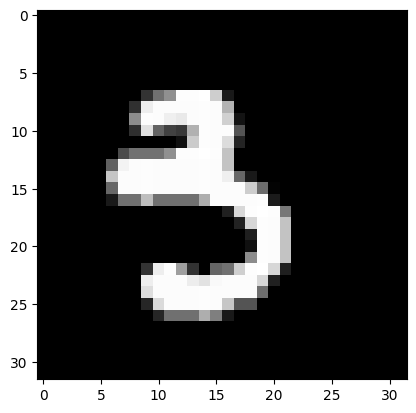

In [18]:
for idx, (inputs,label) in enumerate(test_loader):

    # move to device
    plt.imshow(inputs[0].reshape(32,32), cmap="gray")
    print(label[0])
    inputs = inputs.to(device)

    # forward pass [with feature extraction]
    preds = modelA(inputs)
    print(preds[0])
    if idx == 2:
        break

468
tensor(1)
tensor([-2.4648, 13.2356, -0.7841, -3.3614,  1.5994, -3.1586, -0.5662,  0.0871,
        -1.7180, -2.7579], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0)
tensor([12.4559, -0.7835, -2.4369, -2.6861, -1.1309, -2.6358, -0.0749, -1.1944,
        -1.9712,  0.5849], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(1)
tensor([-2.0671, 12.1510, -0.5456, -1.6371, -0.5938, -1.5457, -1.6369, -1.5649,
         0.2841, -2.7507], device='cuda:0', grad_fn=<SelectBackward0>)
- preds shape: (384, 10)
- feats shape: (384, 64, 8, 8)


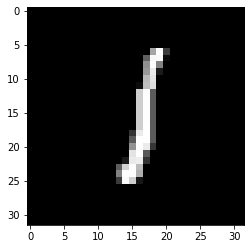

In [ ]:
##### FEATURE EXTRACTION LOOP
import matplotlib.pyplot as plt


def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

model.layer1.register_forward_hook(get_features('feats'))
# placeholders
PREDS = []
FEATS = []

# placeholder for batch features
features = {}
print(len(data_loader))
# loop through batches
for idx, (inputs,label) in enumerate(data_loader):

    # move to device
    plt.imshow(inputs[0].reshape(32,32), cmap="gray")
    print(label[0])
    inputs = inputs.to(device)

       
    # forward pass [with feature extraction]
    preds = model(inputs)
    print(preds[0])
    
    # add feats and preds to lists
    PREDS.append(preds.detach().cpu().numpy())
    FEATS.append(features['feats'].cpu().numpy())

    # early stop
    if idx == 2:
        break
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print('- preds shape:', PREDS.shape)
print('- feats shape:', FEATS.shape)

In [ ]:
##### HELPER FUNCTION FOR FEATURE EXTRACTION


In [ ]:
#add hook to layer 2
model.layer2.register_forward_hook(get_features('feats'))

In [ ]:
PREDS = np.concatenate(PREDS)
FEATS = np.concatenate(FEATS)

print('- preds shape:', PREDS.shape)
print('- feats shape:', FEATS.shape)


- preds shape: (384, 10)
- feats shape: (384, 128, 4, 4)


In [ ]:
def stitching_layer(x,model):
  c1 =64
  c2= 128
  x = nn.BatchNorm2d(c1)(x)
  x = nn.Conv2d(in_channels = c1, out_channels = c2,kernel_size=1)(x)
  x = nn.BatchNorm2d(c2)(x)

  return x

stitching_layer(FEATS, model)

AttributeError: ignored

In [ ]:
PREDS[0][0]